In [1]:
import subprocess
import datetime
import os

import pandas as pd
from datetime import datetime


def gen_exec(cmd, check_return: bool = False):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line
    popen.stdout.close()
    return_code = popen.wait()
    if return_code and check_return:
        raise subprocess.CalledProcessError(return_code, cmd)


def exec_bash(cmd: str, check_return: bool = False):
    return [s for s in gen_exec(cmd.split(), check_return)]
    
def exec_bash_print(cmd: str, check_return: bool = False):
    for path in gen_exec(cmd.split(), check_return):
        print(path, end="")
        
def strtime():
    return datetime.now().strftime("%y%m%d_%H%M%S")



from pathlib import Path

prj_path = Path(str(Path("../../../").resolve())+"/")
exp_folder = Path(prj_path, "papers/neurips21/")
res_folder = Path(exp_folder, "output")
model_folder = Path(exp_folder, "models")

jar_file = Path(prj_path, "target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar")
javafile = Path(exp_folder, "Experiments.java")
#java = "/Library/Java/JavaVirtualMachines/openjdk-12.0.1.jdk/Contents/Home/bin/java"
java = "java"


print(prj_path)
print(exp_folder)
print(res_folder)
print(model_folder)

print(jar_file)

/root/dev/credici
/root/dev/credici/papers/neurips21
/root/dev/credici/papers/neurips21/output
/root/dev/credici/papers/neurips21/models
/root/dev/credici/target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar


In [7]:
# First results with 4 and 6
#labels = ["210517_185931", "210517_190132", "210517_190139", "210517_212428"] # 210517_161626

## markovian and quasi markovian larger modes
#labels = ["210519_182425", "210519_182654", "210519_182800"]

# first sequentials
labels = ["210520_195427", "210520_195439", "210520_194904"]

###############
# sets s0 s1a s1b
labels = ["210521_184054", "210521_184137", "210521_184122", "210522_060520", "210522_060542", "210522_060535"]
# s2 s2_2
labels += ["210523_131019", "210523_131014"]
#s2_3
labels += ["210523_170457"]

#sv0 sv1 #sv2
labels += ["210524_183436", "210524_183454", "210524_183454"]
#sv0_2 sv1_2 #sv2_2
labels += ["210524_222523", "210524_222459", "210524_222512"]

labels += ["210525_081042", "210525_081050"]


#############
#labels = ["210524_105434", "210524_131140", "210524_131149"]

In [8]:
from collections.abc import Iterable
import numpy as np


#def load_data():

F = [Path(res_folder, l) for l in labels] 

res_list = []

for output_folder in F:
    resfiles = [f for f in os.listdir(output_folder) if f.endswith(".py")]

    for r in resfiles:
        try:
            exec(Path(output_folder, r).read_text())
            res_list.append(results)
        except Exception:
            print(f"error in {r}")

print(len(res_list))



def to_pandas(res_dict):

    simple_cols = [c for c in res_dict.keys() if not isinstance(res_dict[c], Iterable) or isinstance(res_dict[c], str)]
    df1 = pd.DataFrame.from_dict({k:[res_dict[k]] for k in simple_cols})
    list_cols = [c for c in res_dict.keys() if c not in simple_cols]

    if len(list_cols)>1:
        df2 = pd.DataFrame.from_dict({k:res_dict[k] for k in list_cols})
        df = pd.concat([pd.concat([df1]*len(df2)).reset_index(drop=True), df2], axis=1)

    else:
        df = df1    

    df = df.reset_index(drop=False)
    df = df.rename(columns = dict(index="numPoints"))

    df["numPoints"] += 1

    df.columns

    columns = ['seed', 'markovian','error', 'nEndo','nExo', 'exoTW', 'errorMsg', 'folder', 'file', 'groundtruth',
              'timeBuild', 'timeExact', 'timeQuery',
              'pnsExact_l','pnsExact_u', 'pnsEM_l', 'pnsEM_u',  'numPoints','innerPoints', 'llkratio',
              'iterEM']

    columns = [c for c in columns if c in df.columns] + [c for c in df.columns if c not in columns]


    df = df[columns]
    return df

data = pd.concat([to_pandas(r) for r in res_list]).reset_index(drop=True)

# replace exact == -1 by NaN or None
data.loc[data.pnsExact_l == -1, "pnsExact_l"] = np.nan
data.loc[data.pnsExact_u == -1, "pnsExact_u"] = np.nan

# add exactEvaluable 

data["exact_eval"] = ~data["pnsExact_l"].isna()

# calculate RMSE


def rmse_pns(t): return np.sqrt((t["pnsEM_l"] - t["pnsExact_l"])**2 + (t["pnsEM_u"] - t["pnsExact_u"])**2)
data["rmse_pns"] = data.apply(rmse_pns, axis=1)

data["id"] = (data["folder"] + "_"+ data["file"]).str.replace(".uai", "")

#    return data

#data = load_data()


error in s1b_chain_twExo1_nEndo15_19.uai_x20_pLAST_m200_s0.py
error in s1a_chain_twExo1_nEndo5_2.uai_x20_pLAST_m200_s0.py
error in s1a_2_chain_twExo1_nEndo5_21.uai_x20_pLAST_m200_s0.py
error in s1b_2_chain_twExo1_nEndo5_36.uai_x20_pLAST_m200_s0.py
403


<ipython-input-8-4fbf886ce0e1>:72: FutureWarning: The default value of regex will change from True to False in a future version.
  data["id"] = (data["folder"] + "_"+ data["file"]).str.replace(".uai", "")


In [9]:
data.markovian==True

0        True
1        True
2        True
3        True
4        True
        ...  
7447    False
7448    False
7449    False
7450    False
7451    False
Name: markovian, Length: 7452, dtype: bool

In [10]:
# plot RMSE vs numPoints
import matplotlib.pyplot as plt

# plot 3 a line for each nEndo

#df= data.loc[(data.markovian==True) & (data.exoTW==1)]
df = data.loc[(data.markovian==False) & (data.exoTW==2)]
title=None
nEndo = None

def plot_rmse(df, title=None, nEndo = None):
    print(len(df[df.numPoints==1]))

    df = df[["numPoints", "rmse_pns", "exact_eval", "nEndo"]]#.dropna()

    print(len(df[df.numPoints==1]))

    group_vars = ["numPoints"]

    if nEndo is not None: 
        group_vars +=  ["nEndo"]

    group = df[["numPoints", "rmse_pns", "exact_eval", "nEndo"]].groupby(group_vars)

    df = group.mean()

    fig, ax = plt.subplots()

    if nEndo is not None:
        df = df.reset_index()
        for n in nEndo:
            y = df[df.nEndo== n]["rmse_pns"]
            x = df[df.nEndo== n]["numPoints"]
            plt.plot(x,y, label=f"#endog = {int(n)}")
    else:
        #print(df.columns)
        x = df["rmse_pns"]
        #print
        #y = df["numPoints"]

        plt.plot(x)


    ax.legend()

    ax.set(ylabel='RMSE', xlabel='EM runs',
           title=title)
    ax.grid()

df

,seed,markovian,error,nEndo,nExo,exoTW,errorMsg,folder,file,groundtruth,...,innerPoints,llkratio,iterEM,compatible,klpq,klsym,klqp,exact_eval,rmse_pns,id
2446,0.0,False,True,15.0,12.0,2.0,java.util.concurrent.TimeoutException,s2,chain_twExo2_nEndo15_17.uai,saturation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,s2_chain_twExo2_nEndo15_17
2447,0.0,False,False,5.0,4.0,2.0,,s2,chain_twExo2_nEndo5_18.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.001300,s2_chain_twExo2_nEndo5_18
2448,0.0,False,False,5.0,4.0,2.0,,s2,chain_twExo2_nEndo5_18.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.001298,s2_chain_twExo2_nEndo5_18
2449,0.0,False,False,5.0,4.0,2.0,,s2,chain_twExo2_nEndo5_18.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.001298,s2_chain_twExo2_nEndo5_18
2450,0.0,False,False,5.0,4.0,2.0,,s2,chain_twExo2_nEndo5_18.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.001298,s2_chain_twExo2_nEndo5_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,0.0,False,False,7.0,4.0,2.0,,sv2_2,chain_twExo2_nEndo7_36.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.000000,sv2_2_chain_twExo2_nEndo7_36
5926,0.0,False,False,7.0,4.0,2.0,,sv2_2,chain_twExo2_nEndo7_36.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.000000,sv2_2_chain_twExo2_nEndo7_36
5927,0.0,False,False,7.0,4.0,2.0,,sv2_2,chain_twExo2_nEndo7_36.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.000000,sv2_2_chain_twExo2_nEndo7_36
5928,0.0,False,False,7.0,4.0,2.0,,sv2_2,chain_twExo2_nEndo7_36.uai,saturation,...,0.0,NaN,200.0,NaN,NaN,NaN,NaN,True,0.000000,sv2_2_chain_twExo2_nEndo7_36


133
133


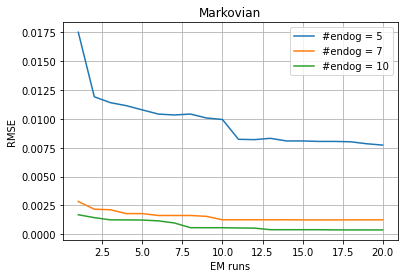

In [11]:
plot_rmse(data.loc[(data.markovian==True) & (data.exoTW==1) & (data.nEndo>0)], nEndo = [5,7, 10], title = "Markovian")
#data["exact_eval"]
#data.loc[(data.markovian==False) ]



132
132


29

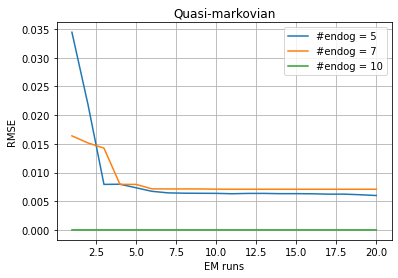

In [15]:
plot_rmse(data.loc[(data.markovian==False)  & (data.exoTW==1) & (data.nEndo >0)],
          #split_endo=False,
          title = "Quasi-markovian",
          nEndo = [5,7, 10])


# todo: add more 5 and 10
data.loc[(data.markovian==False) & (data.exoTW==1) & (data.nEndo==10) & (data.numPoints==1), "numPoints"].sum()


137
137


40

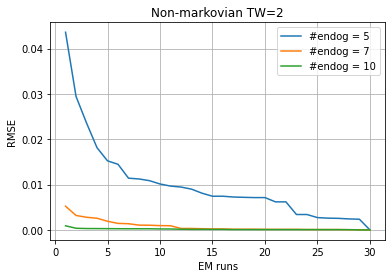

In [66]:
plot_rmse(data.loc[(data.markovian==False) & (data.exoTW==2)],  
          nEndo = [5,7, 10], 
          title="Non-markovian TW=2")

data.loc[(data.markovian==False) & (data.exoTW==2) & (data.nEndo==10) & (data.numPoints==1), "numPoints"].sum()


In [90]:
# plot share of compatible data
# plot histogram llk-ratio exactEvaluable or not exactEvaluable

In [91]:
data

,seed,markovian,error,nEndo,nExo,exoTW,errorMsg,folder,file,groundtruth,...,innerPoints,llkratio,iterEM,compatible,klpq,klsym,klqp,exact_eval,rmse_pns,id
0,0.0,True,False,10.0,10.0,1.0,,s0,chain_twExo0_nEndo10_4.uai,cve,...,0.0,0.996845,160.0,False,0.000691,0.001382,0.000691,True,0.000000,s0_chain_twExo0_nEndo10_4
1,0.0,True,False,10.0,10.0,1.0,,s0,chain_twExo0_nEndo10_4.uai,cve,...,0.0,0.996845,169.0,False,0.000691,0.001382,0.000691,True,0.000000,s0_chain_twExo0_nEndo10_4
2,0.0,True,False,10.0,10.0,1.0,,s0,chain_twExo0_nEndo10_4.uai,cve,...,0.0,0.996845,159.0,False,0.000691,0.001382,0.000691,True,0.000000,s0_chain_twExo0_nEndo10_4
3,0.0,True,False,10.0,10.0,1.0,,s0,chain_twExo0_nEndo10_4.uai,cve,...,0.0,0.996845,200.0,False,0.000691,0.001382,0.000691,True,0.000000,s0_chain_twExo0_nEndo10_4
4,0.0,True,False,10.0,10.0,1.0,,s0,chain_twExo0_nEndo10_4.uai,cve,...,0.0,0.996845,150.0,False,0.000691,0.001382,0.000691,True,0.000000,s0_chain_twExo0_nEndo10_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5384,0.0,False,False,7.0,4.0,1.0,,sv1,chain_twExo1_nEndo7_0.uai,cve,...,0.0,NaN,200.0,False,NaN,NaN,NaN,True,0.000534,sv1_chain_twExo1_nEndo7_0
5385,0.0,False,False,7.0,4.0,1.0,,sv1,chain_twExo1_nEndo7_0.uai,cve,...,0.0,NaN,200.0,False,NaN,NaN,NaN,True,0.000534,sv1_chain_twExo1_nEndo7_0
5386,0.0,False,False,7.0,4.0,1.0,,sv1,chain_twExo1_nEndo7_0.uai,cve,...,0.0,NaN,200.0,False,NaN,NaN,NaN,True,0.000534,sv1_chain_twExo1_nEndo7_0
5387,0.0,False,False,7.0,4.0,1.0,,sv1,chain_twExo1_nEndo7_0.uai,cve,...,0.0,NaN,200.0,False,NaN,NaN,NaN,True,0.000534,sv1_chain_twExo1_nEndo7_0


In [92]:
group = data[["id", "llkratio"]].groupby("id")

In [14]:
llk_info = pd.concat(
    [group.mean().rename(columns=dict(llkratio="avg_llkratio")),
     group.min().rename(columns=dict(llkratio="min_llkratio")),
     group.max().rename(columns=dict(llkratio="max_llkratio")),
    ],axis = 1)
     
    
llk_info = data[["id","markovian", "exoTW", "nEndo", "nExo", "exact_eval"]].groupby("id").mean().merge(llk_info, on="id")

llk_info

#llk_info.to_csv(Path(output_folder,"llk_info.csv"))

,markovian,exoTW,nEndo,nExo,exact_eval,avg_llkratio,min_llkratio,max_llkratio
id,,,,,,,,
seq0_chain_twExo0_nEndo10_10,True,1,10,10,True,0.513017,0.512986,0.513168
seq0_chain_twExo0_nEndo10_13,True,1,10,10,True,0.440542,0.433765,0.445780
seq0_chain_twExo0_nEndo10_14,True,1,10,10,True,0.786114,0.786092,0.786123
seq0_chain_twExo0_nEndo10_19,True,1,10,10,False,NaN,NaN,NaN
seq0_chain_twExo0_nEndo10_2,True,1,10,10,True,0.299050,0.295599,0.303093
seq0_chain_twExo0_nEndo10_6,True,1,10,10,True,0.000000,0.000000,0.000000
seq0_chain_twExo0_nEndo15_17,True,1,15,15,False,NaN,NaN,NaN
seq0_chain_twExo0_nEndo15_18,True,1,15,15,True,0.590369,0.590308,0.590733
seq0_chain_twExo0_nEndo15_2,True,1,15,15,False,NaN,NaN,NaN


In [15]:
sum(llk_info["exact_eval"]==True)

28

In [16]:
sum(llk_info["exact_eval"]==False)

6

<AxesSubplot:>

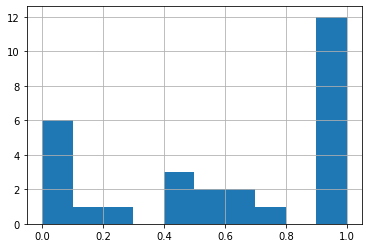

In [17]:
## Average llk-ratio when data is compatible
llk_info.loc[llk_info.exact_eval==True, "avg_llkratio"].hist()

<AxesSubplot:>

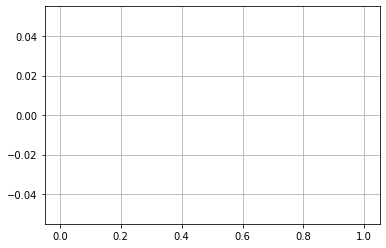

In [18]:
## Average llk-ratio when data is not compatible
llk_info.loc[llk_info.exact_eval==False, "avg_llkratio"].hist()

<AxesSubplot:>

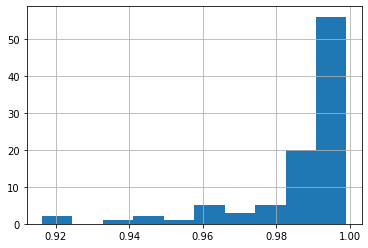

In [19]:
## Average llk-ratio when data is compatible
llk_info.loc[(llk_info.exact_eval==True) & (llk_info.avg_llkratio>0.8), "avg_llkratio"].hist()

<AxesSubplot:>

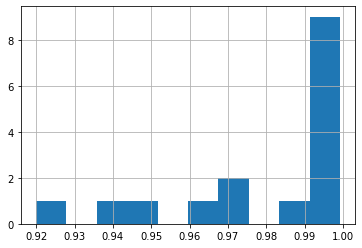

In [20]:
## Average llk-ratio when data is compatible
llk_info.loc[(llk_info.exact_eval==False) & (llk_info.avg_llkratio>0.8), "avg_llkratio"].hist()

In [21]:
-float("inf")

-inf

In [22]:
# KLpq, KLsym  for compatible vs not compatible and mark and quasi-mark
data.columns

Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeExact', 'timeQuery',
       'pnsExact_l', 'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints',
       'innerPoints', 'llkratio', 'iterEM', 'klpq', 'klsym', 'klqp',
       'exact_eval', 'rmse_pns', 'id'],
      dtype='object')

In [23]:
group = data[["id", 'klpq', 'klsym', 'klqp']].groupby("id")
kl_info = group.mean()
kl_info = data[["id","markovian", "exoTW", "nEndo", "nExo", "exact_eval"]].groupby("id").mean().merge(kl_info, on="id")
kl_info

,exoTW,nEndo,nExo,exact_eval,klpq,klsym,klqp
id,,,,,,,
set1_chain_twExo0_nEndo4_10,1.0,4.0,4.0,True,0.000698,0.001294,0.000596
set1_chain_twExo0_nEndo4_16,1.0,4.0,4.0,True,0.000530,0.001069,0.000538
set1_chain_twExo0_nEndo4_17,1.0,4.0,4.0,True,0.000826,0.001604,0.000778
set1_chain_twExo0_nEndo4_18,1.0,4.0,4.0,True,0.000222,0.000444,0.000222
set1_chain_twExo0_nEndo4_2,1.0,4.0,4.0,True,0.000834,0.001679,0.000846
...,...,...,...,...,...,...,...
set3_chain_twExo3_nEndo6_3,3.0,6.0,6.0,True,0.003712,0.007408,0.003696
set3_chain_twExo3_nEndo6_6,3.0,6.0,6.0,True,0.002410,0.004724,0.002314
set3_chain_twExo3_nEndo6_7,NaN,NaN,NaN,False,NaN,NaN,NaN


<AxesSubplot:>

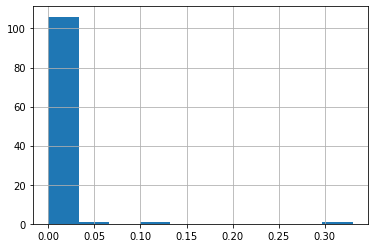

In [24]:
kl_info.loc[llk_info.exact_eval==True, "klpq"].hist()

<AxesSubplot:>

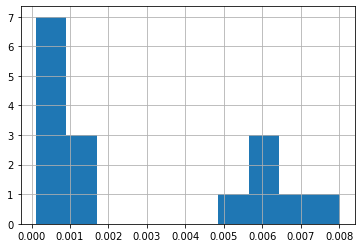

In [25]:
kl_info.loc[llk_info.exact_eval==False, "klpq"].hist()

In [153]:
i=3
data[data.groundtruth == "saturation"][['pnsExact_l',
       'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints', 'klpq', 'llkratio']].iloc[i*20:i*20+20]

,pnsExact_l,pnsExact_u,pnsEM_l,pnsEM_u,numPoints,klpq,llkratio
120,0.000301,0.002791,0.001974,0.001974,1,0.006496,0.973080
121,0.000301,0.002791,0.001974,0.002767,2,0.005738,0.976149
122,0.000301,0.002791,0.000301,0.002767,3,0.008010,0.967015
123,0.000301,0.002791,0.000301,0.002767,4,0.004603,0.980774
124,0.000301,0.002791,0.000301,0.002767,5,0.004695,0.980398
125,0.000301,0.002791,0.000301,0.002767,6,0.006142,0.974513
126,0.000301,0.002791,0.000301,0.002767,7,0.002760,0.988385
127,0.000301,0.002791,0.000301,0.002767,8,0.003584,0.984969
128,0.000301,0.002791,0.000301,0.002767,9,0.001494,0.993678
129,0.000301,0.002791,0.000301,0.002767,10,0.003892,0.983696


In [154]:
data.columns

Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeQuery', 'pnsExact_l',
       'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints', 'innerPoints',
       'llkratio', 'iterEM', 'klpq', 'klsym', 'klqp', 'timeExact',
       'exact_eval', 'rmse_pns', 'id'],
      dtype='object')